#📌 Extracão

In [1]:
import requests
import pandas as pd

url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)

data = response.json()
df = pd.DataFrame(data)


#🔧 Código para Pré-processamento

> Adicionar aspas



In [2]:
import requests
import pandas as pd

url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)

data = response.json()
df = pd.DataFrame(data)

# 1. Transformar a coluna 'Churn' de 'Yes'/'No' para 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 2. Extrair as informações dos dicionários nas colunas 'customer', 'phone', 'internet' e 'account'
# Utilizando apply(pd.Series) para expandir os dicionários em colunas

# 2.1. Extraindo 'customer' para novas colunas
customer_df = df['customer'].apply(pd.Series)
df = pd.concat([df, customer_df], axis=1)

# 2.2. Extraindo 'phone' para novas colunas
phone_df = df['phone'].apply(pd.Series)
df = pd.concat([df, phone_df], axis=1)

# 2.3. Extraindo 'internet' para novas colunas
internet_df = df['internet'].apply(pd.Series)
df = pd.concat([df, internet_df], axis=1)

# 2.4. Extraindo 'account' para novas colunas
account_df = df['account'].apply(pd.Series)
df = pd.concat([df, account_df], axis=1)


# 3. Remover as colunas originais que continham os dicionários
df = df.drop(columns=['customer', 'phone', 'internet', 'account'])

# Verificando o formato do dataset após as mudanças
print(f"\nNovo formato do dataset: {df.shape}")
print(df.head())


Novo formato do dataset: (7267, 20)
   customerID  Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    0.0  Female              0     Yes        Yes       9   
1  0003-MKNFE    0.0    Male              0      No         No       9   
2  0004-TLHLJ    1.0    Male              0      No         No       4   
3  0011-IGKFF    1.0    Male              1     Yes         No      13   
4  0013-EXCHZ    1.0  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
0          Yes            No             DSL             No          Yes   
1          Yes           Yes             DSL             No           No   
2          Yes            No     Fiber optic             No           No   
3          Yes            No     Fiber optic             No          Yes   
4          Yes            No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies   

#Criação do Modelo Preditivo

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# Drop rows with NaN in the target variable 'Churn'
df.dropna(subset=['Churn'], inplace=True)

# 1. Separar as variáveis independentes (X) e a variável dependente (y)
X = df.drop(columns=['Churn', 'customerID'])  # Exclui 'Churn' (target) e 'customerID' (não relevante)
y = df['Churn']

# Handle the 'Charges' column which contains dictionaries
X['MonthlyCharges'] = X['Charges'].apply(lambda x: x.get('Monthly'))
X['TotalCharges'] = X['Charges'].apply(lambda x: x.get('Total'))

# Convert 'TotalCharges' to numeric, coercing errors
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')

# Drop the original 'Charges' column
X = X.drop(columns=['Charges'])


# Identify categorical columns (excluding the new numeric charge columns)
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

# Handle potential NaN values after one-hot encoding (e.g., from coerced TotalCharges)
# A common strategy is to fill with the mean, median, or a constant. Mean is used here as an example.
X.fillna(X.mean(), inplace=True)


# 2. Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Criar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# 4. Treinar o modelo
rf_model.fit(X_train, y_train)

# 5. Fazer previsões
y_pred = rf_model.predict(X_test)

# 6. Avaliar o modelo
print("Acurácia do Modelo: ", rf_model.score(X_test, y_test))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nAUC-ROC: ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

Acurácia do Modelo:  0.7885024840312278

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      1036
         1.0       0.64      0.45      0.53       373

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.77      1409


Matriz de Confusão:
 [[944  92]
 [206 167]]

AUC-ROC:  0.8149448280145332


#📄Identificação de Maior Risco

Características mais importantes para o risco de evasão:
                           Feature  Importance
3                     TotalCharges    0.159498
1                           tenure    0.141076
2                   MonthlyCharges    0.137052
36         Contract_Month-to-month    0.050973
43  PaymentMethod_Electronic check    0.036193


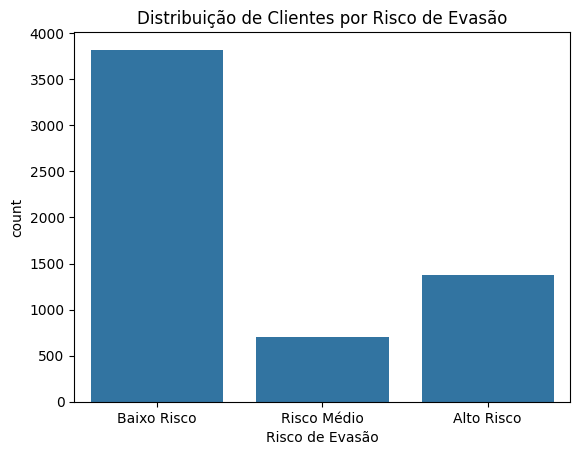

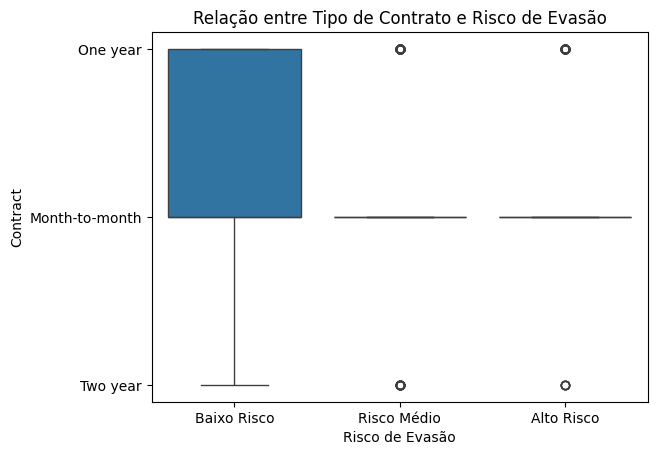

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gerar as probabilidades de evasão para os clientes
df['Churn_prob'] = rf_model.predict_proba(X)[:, 1]

# 2. Definir segmentos de risco baseado na probabilidade de churn
# Aqui, estamos criando 3 segmentos: baixo (0-0.3), médio (0.3-0.7), alto (0.7-1.0)
conditions = [
    (df['Churn_prob'] <= 0.3),
    (df['Churn_prob'] > 0.3) & (df['Churn_prob'] <= 0.7),
    (df['Churn_prob'] > 0.7)
]

choices = ['Baixo Risco', 'Risco Médio', 'Alto Risco']

df['Risco de Evasão'] = pd.cut(df['Churn_prob'], bins=[0, 0.3, 0.7, 1], labels=choices)

# 3. Analisar quais características dos clientes estão mais associadas ao risco
# Podemos analisar a importância das variáveis (feature importance)
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Criar um dataframe com as importâncias e ordenar
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Mostrar as variáveis mais importantes
print("Características mais importantes para o risco de evasão:")
print(importance_df.head())

# 4. Visualização do risco de evasão
# Contagem de clientes por risco
sns.countplot(x='Risco de Evasão', data=df)
plt.title('Distribuição de Clientes por Risco de Evasão')
plt.show()

# 5. Visualizar a relação entre as variáveis mais importantes e o risco de evasão
# Exemplo: Vamos analisar como o risco de evasão se relaciona com o 'Contract' (duração do contrato)
sns.boxplot(x='Risco de Evasão', y='Contract', data=df)
plt.title('Relação entre Tipo de Contrato e Risco de Evasão')
plt.show()



#📄descobrir as variáveis mais relevantes

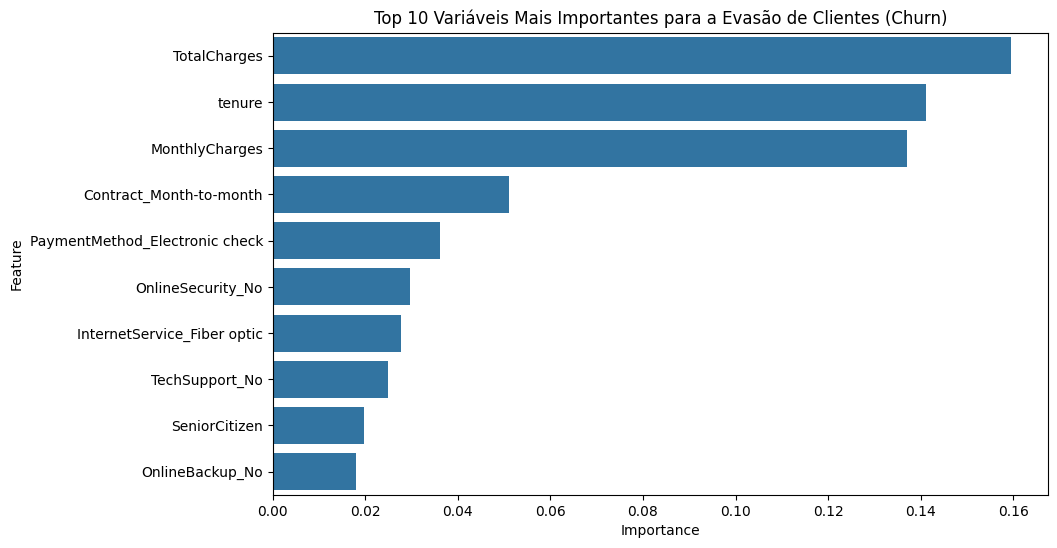

Top 10 variáveis mais importantes para a previsão de churn:
                           Feature  Importance
3                     TotalCharges    0.159498
1                           tenure    0.141076
2                   MonthlyCharges    0.137052
36         Contract_Month-to-month    0.050973
43  PaymentMethod_Electronic check    0.036193
18               OnlineSecurity_No    0.029729
16     InternetService_Fiber optic    0.027719
27                  TechSupport_No    0.024877
0                    SeniorCitizen    0.019819
21                 OnlineBackup_No    0.017889


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obter a importância das variáveis
feature_importance = rf_model.feature_importances_

# 2. Criar um DataFrame com as variáveis e suas importâncias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# 3. Ordenar as variáveis por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 4. Visualizar as top 10 variáveis mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Variáveis Mais Importantes para a Evasão de Clientes (Churn)')
plt.show()

# 5. Exibir as 10 variáveis mais importantes
print("Top 10 variáveis mais importantes para a previsão de churn:")
print(importance_df.head(10))
